#**LABORATORIO 02 - REDES CONVOLUCIONALES**

##Nombre: Quispe Sucullani Jose David

##C.U. 111-376

##Link GitHub:

##CONTEXTO DEL LABORATORIO

Laboratorio:

1. Con el dataset elaborado, construir una red neuronal convolucional que permita identificar (clasificar) los diferentes residuos solidos que se puedan obtener a partir de una imagen fotográfica, es decir se deben utilizar el dataset para entrenar y validar la efectividad del modelo desarrollado, se debe aplicar las técnicas que considere necesarias de las revisadas para lograr obtener los mejores parámetros para el modelo. Las pruebas de la efectividad se realizaran con imágenes que se capturaran con una cámara fotográfica.

2. Realizar lo solicitado en el punto 1, pero utilizando un modelo preentrenado y aplicando técnicas de transfer learning y fine tunning. El modelo preentrenado no debe tener una antiguedad mayor a 5 años.

Se debe elaborar un informe en relación a los resultados que se obtengan en cada parte del trabajo.

El cuadernillo a presentar solo debe tener información que el estudiante considere necesaria.

Se debe subir el cuadernillo a ecampus y a su repositorio, para lo cual se debe incluir la dirección del mismo.

In [1]:
# DESCARGAMOS LAS LIBRERIAS
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch.optim as optim
from tqdm import tqdm
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


1. Preparación del Dataset

Nuestro dataset es sobre 5 tipos de residuo, que son mas de 800 imagenes, en este post aplicaremos todos las tecnicas que se aplican para contruir un modelo de red convolucional.

Nuestro dataset cuenta con 5 tipos de clases: Anillos de lata, Bolsas de soda, Cable de red, Hojas de brocoli, y Monedas.

In [4]:
""""
Leemos el Dataset para trabajar en base de ello, ademas aplicamos las buenas prácticas
como las transformaciones de las imagenes y redimencionamiento a un 50x50 píxeles.
"""

# Definir las transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((50, 50)),  # Redimensionar las imágenes a 50x50 píxeles
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar los tensores
])

# Cargar los datasets de entrenamiento y prueba
train_data = datasets.ImageFolder(root='/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio2/Dataset/train', transform=transform)
test_data = datasets.ImageFolder(root='/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio2/Dataset/test', transform=transform)

# Mostrar la cantidad de imágenes de entrenamiento y prueba
print(f"Número de imágenes de entrenamiento: {len(train_data)}")
print(f"Número de imágenes de prueba: {len(test_data)}")

Número de imágenes de entrenamiento: 4015
Número de imágenes de prueba: 4009


Mostamos alguans imagenes que se capturan a partir de los datos, cada imagen se visualiza com sus respectivas clases.

In [5]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import random

# Definir las transformaciones para el conjunto de datos
transform = transforms.Compose([
    transforms.Resize((50, 50)),  # Redimensionar las imágenes a 50x50 píxeles
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalización de las imágenes
])

# Función para limitar el número de archivos de cada subcarpeta
def limit_dataset_size(root_dir, max_per_class=6000):
    # Diccionario para almacenar rutas de las imágenes seleccionadas por clase
    limited_dataset = []

    # Iteramos por las subcarpetas en root_dir (cada subcarpeta es una clase)
    for class_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            # Obtenemos todas las imágenes en la subcarpeta
            all_images = os.listdir(class_dir)
            # Filtramos para obtener solo imágenes, excluyendo otros tipos de archivos
            all_images = [os.path.join(class_name, img) for img in all_images if img.endswith(('.png', '.jpg', '.jpeg'))]
            # Seleccionamos aleatoriamente 6000 imágenes
            selected_images = random.sample(all_images, min(len(all_images), max_per_class))
            limited_dataset.extend(selected_images)

    return limited_dataset



In [6]:
# Definir la ruta del dataset
root_dir = '/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio2/Dataset/train'

# Obtener una lista de las rutas de imágenes limitadas a 400 por clase
limited_image_paths = limit_dataset_size(root_dir, max_per_class=400)

# Clase personalizada para cargar solo las imágenes seleccionadas
class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, selected_files, transform=None):
        super(CustomImageFolder, self).__init__(root, transform=transform)
        # Filtrar el dataset para cargar solo las imágenes seleccionadas
        self.samples = [(os.path.join(root, img), self.class_to_idx[img.split('/')[0]]) for img in selected_files]
        self.targets = [s[1] for  s in self.samples]  # Extraer las etiquetas

# Crear el dataset personalizado usando solo las imágenes seleccionadas
train_data = CustomImageFolder(root=root_dir, selected_files=limited_image_paths, transform=transform)

# Verificar el número de imágenes en el nuevo conjunto de entrenamiento
print(f"Número total de imágenes en el nuevo conjunto de entrenamiento: {len(train_data)}")

# Verificar el número de imágenes por clase
from collections import Counter
print("Distribución de imágenes por clase:", Counter(train_data.targets))

Número total de imágenes en el nuevo conjunto de entrenamiento: 2000
Distribución de imágenes por clase: Counter({4: 400, 2: 400, 0: 400, 1: 400, 3: 400})


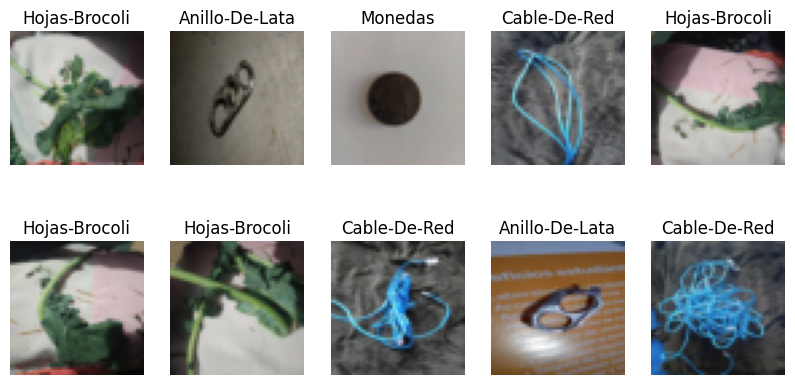

In [7]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Obtener las clases del dataset
classes = train_data.classes

# Convertir las imágenes y etiquetas a arrays numpy para facilitar el procesamiento
def imshow(img):
    img = img / 2 + 0.5     # Desnormalizar
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

# Mostrar 10 imágenes aleatorias
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    index = random.randint(0, len(train_data) - 1)
    img, label = train_data[index]
    plt.imshow(imshow(img))
    plt.title(classes[label])
    plt.axis('off')

plt.show()

##Preparamos el DATALOADER

In [8]:
# Preparar los DataLoaders en formato de diccionario
dataloader = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=True)
}

# Mostrar la cantidad de imágenes de entrenamiento y prueba
# print(f"Número de imágenes de entrenamiento: {len(train_data)}")
# print(f"Número de imágenes de prueba: {len(test_data)}")

##2. Diseño de la Red Convolucional

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

# Bloques de convolución + activación + max pooling + batch normalization
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return nn.Sequential(
        nn.Conv2d(c_in, c_out, kernel_size=k, padding=p, stride=s),
        nn.BatchNorm2d(c_out),  # Batch Normalization
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=pk, stride=ps)
    )

# Bloques de capas totalmente conectadas
def block2(c_in, c_out, dropout_p=0.5):
    return nn.Sequential(
        nn.Linear(c_in, c_out),
        nn.ReLU(),
        nn.Dropout(dropout_p)  # Dropout para regularización
    )

class CNN(nn.Module):
    def __init__(self, n_channels=3, n_outputs=5):
        super().__init__()

        # Capas convolucionales con batch normalization
        self.conv1 = block(n_channels, 32)
        self.conv2 = block(32, 64)
        self.conv3 = block(64, 128)

        # Capas fully connected con Dropout
        self.fc1 = block2(128 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, n_outputs)

    def forward(self, x):
        # Capas convolucionales
        # print("Dimensiones:")
        # print("Entrada: ", x.shape)
        x = self.conv1(x)
        # print("conv1: ", x.shape)
        x = self.conv2(x)
        # print("conv2: ", x.shape)
        x = self.conv3(x)
        # print("conv3: ", x.shape)

        # Aplanar para las fully connected
        x = x.view(x.shape[0], -1)
        # print("pre fc: ", x.shape)

        # Capas fully connected
        x = self.fc1(x)
        x = self.fc2(x)
        # print("Salida: ", x.shape)

        return x


In [10]:
# Crear el modelo
model = CNN()

In [11]:

# Probar el modelo con un lote de imágenes de entrada simuladas de 50x50 y 3 canales
# (ya que el dataset tiene imágenes RGB)
output = model(torch.randn(64, 3, 50, 50))
print(output.shape)


torch.Size([64, 5])


##3. Entrenamiento del Modelo Con CheckPoint

In [12]:
# Directorio donde se guardarán los checkpoints
checkpoint_dir = "/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio2"

# Función para guardar un checkpoint en la ruta especificada
def save_checkpoint(epoch, model, optimizer, loss, filename='checkpoint.pth'):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    full_path = os.path.join(checkpoint_dir, filename)  # Construir la ruta completa
    torch.save(checkpoint, full_path)
    print(f'Checkpoint guardado en: {full_path}')


In [13]:
def fit(model, dataloader, epochs=10, lr=1e-3, weight_decay=1e-4, save_interval=5):
    """
    Entrenamiento del modelo con optimizaciones, regularización y guardado de checkpoints.

    Args:
    - model: El modelo de CNN.
    - dataloader: Diccionario que contiene los dataloaders de 'train' y 'test'.
    - epochs: Número de épocas de entrenamiento.
    - lr: Learning rate inicial.
    - weight_decay: Tasa de regularización L2.
    - save_interval: Intervalo de épocas para guardar los checkpoints.
    """

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # Optimizador Adam con L2 regularization
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)  # Scheduler para reducir el LR
    criterion = torch.nn.CrossEntropyLoss()  # Pérdida

    # Listas para almacenar las métricas por época
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(1, epochs + 1):
        # Entrenamiento
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'], desc=f"Epoch {epoch}/{epochs}")

        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)

            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        # Validación
        model.eval()
        val_loss, val_acc = [], []
        bar = tqdm(dataloader['test'], desc=f"Validation")

        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)

                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)

                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")

        # Almacenar las métricas de la época
        history['train_loss'].append(np.mean(train_loss))
        history['train_acc'].append(np.mean(train_acc))
        history['val_loss'].append(np.mean(val_loss))
        history['val_acc'].append(np.mean(val_acc))


        # Reducir el learning rate si no mejora la validación
        scheduler.step(np.mean(val_loss))

        # Imprimir métricas de entrenamiento y validación
        print(f"Epoch {epoch}/{epochs} - loss: {np.mean(train_loss):.5f}, val_loss: {np.mean(val_loss):.5f}, "
              f"acc: {np.mean(train_acc):.5f}, val_acc: {np.mean(val_acc):.5f}")

        # Guardar un checkpoint cada 'save_interval' epochs
        if epoch % save_interval == 0:
            checkpoint_filename = f"checkpoint_epoch_{epoch}.pth"
            save_checkpoint(epoch, model, optimizer, np.mean(val_loss), filename=checkpoint_filename)

    return history

In [14]:
# Suponiendo que ya tengas el modelo y los dataloaders preparados:
fit(model, dataloader, epochs=10, lr=1e-3, weight_decay=1e-4, save_interval=2)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
val_loss 1.36402 val_acc 0.73487: 100%|██████████| 63/63 [23:55<00:00, 22.78s/it]


Epoch 1/10 - loss: 0.30996, val_loss: 1.36402, acc: 0.88135, val_acc: 0.73487


val_loss 1.05826 val_acc 0.79291: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Epoch 2/10 - loss: 0.02493, val_loss: 1.05826, acc: 0.99365, val_acc: 0.79291
Checkpoint guardado en: /content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio2/checkpoint_epoch_2.pth


val_loss 1.52231 val_acc 0.77282: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Epoch 3/10 - loss: 0.01735, val_loss: 1.52231, acc: 0.99707, val_acc: 0.77282


val_loss 1.62091 val_acc 0.79563: 100%|██████████| 63/63 [00:30<00:00,  2.10it/s]


Epoch 4/10 - loss: 0.00662, val_loss: 1.62091, acc: 0.99951, val_acc: 0.79563
Checkpoint guardado en: /content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio2/checkpoint_epoch_4.pth


val_loss 1.25850 val_acc 0.81944: 100%|██████████| 63/63 [00:29<00:00,  2.10it/s]


Epoch 5/10 - loss: 0.01806, val_loss: 1.25850, acc: 0.99756, val_acc: 0.81944


val_loss 1.62106 val_acc 0.78816: 100%|██████████| 63/63 [00:30<00:00,  2.10it/s]


Epoch 6/10 - loss: 0.06058, val_loss: 1.62106, acc: 0.98340, val_acc: 0.78816
Checkpoint guardado en: /content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio2/checkpoint_epoch_6.pth


val_loss 1.31678 val_acc 0.79539: 100%|██████████| 63/63 [00:30<00:00,  2.08it/s]


Epoch 7/10 - loss: 0.01571, val_loss: 1.31678, acc: 0.99609, val_acc: 0.79539


val_loss 1.27931 val_acc 0.79812: 100%|██████████| 63/63 [00:29<00:00,  2.13it/s]


Epoch 8/10 - loss: 0.00998, val_loss: 1.27931, acc: 0.99609, val_acc: 0.79812
Checkpoint guardado en: /content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio2/checkpoint_epoch_8.pth


val_loss 1.30842 val_acc 0.79439: 100%|██████████| 63/63 [00:30<00:00,  2.10it/s]


Epoch 9/10 - loss: 0.00683, val_loss: 1.30842, acc: 0.99854, val_acc: 0.79439


val_loss 1.33072 val_acc 0.80184: 100%|██████████| 63/63 [00:29<00:00,  2.12it/s]

Epoch 10/10 - loss: 0.02310, val_loss: 1.33072, acc: 0.99365, val_acc: 0.80184
Checkpoint guardado en: /content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio2/checkpoint_epoch_10.pth


{'train_loss': [np.float64(0.3099588541081175),
  np.float64(0.02492814180732239),
  np.float64(0.017354916079057148),
  np.float64(0.00661668335487775),
  np.float64(0.018063270462562286),
  np.float64(0.060584929648030084),
  np.float64(0.015713251235865755),
  np.float64(0.009979324131563772),
  np.float64(0.006829075638961513),
  np.float64(0.023099979865946807)],
 'train_acc': [np.float64(0.88134765625),
  np.float64(0.99365234375),
  np.float64(0.9970703125),
  np.float64(0.99951171875),
  np.float64(0.99755859375),
  np.float64(0.9833984375),
  np.float64(0.99609375),
  np.float64(0.99609375),
  np.float64(0.99853515625),
  np.float64(0.99365234375)],
 'val_loss': [np.float64(1.364021080950763),
  np.float64(1.0582647463199197),
  np.float64(1.522308551675791),
  np.float64(1.6209078920727389),
  np.float64(1.2585034616908826),
  np.float64(1.621062054226058),
  np.float64(1.3167759006682822),
  np.float64(1.2793066959155208),
  np.float64(1.308422051159452),
  np.float64(1.3307

##Evaluación del Modelo

In [15]:
def evaluate(model, dataloader):
    """
    Evalúa el modelo en un conjunto de datos (dataloader).
    Retorna la pérdida promedio y la precisión promedio.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()  # Modo de evaluación
    val_loss, val_acc = [], []  # Inicializar listas para almacenar pérdida y precisión
    criterion = torch.nn.CrossEntropyLoss()  # Función de pérdida

    with torch.no_grad():  # No calcular gradientes durante la evaluación
        for batch in tqdm(dataloader, desc="Evaluating"):  # Progreso de evaluación
            X, y = batch  # Obtener el batch de datos y etiquetas
            X, y = X.to(device), y.to(device)  # Mover los datos al dispositivo (GPU/CPU)

            y_hat = model(X)  # Realizar predicciones
            loss = criterion(y_hat, y)  # Calcular la pérdida

            val_loss.append(loss.item())  # Almacenar la pérdida del batch
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)  # Calcular la precisión
            val_acc.append(acc)  # Almacenar la precisión del batch

    # Calcular la pérdida y precisión promedio
    avg_loss = np.mean(val_loss)
    avg_acc = np.mean(val_acc)

    print(f"Evaluation - loss: {avg_loss:.5f}, acc: {avg_acc:.5f}")
    return avg_loss, avg_acc


In [16]:
# Evaluar el modelo en el conjunto de prueba
evaluate(model, dataloader['test'])


Evaluating: 100%|██████████| 63/63 [00:29<00:00,  2.10it/s]

Evaluation - loss: 1.33072, acc: 0.80184


(np.float64(1.330718442407011), np.float64(0.8018353174603174))

##CARGAMOS LOS MODELOS ENTRENADOS.



###Cargamos el modelo entrenado

In [17]:
# Mover el modelo al dispositivo adecuado (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=4608, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.

In [18]:
import torch

# Crear una instancia del modelo (asegúrate de que la arquitectura sea la misma)
model = CNN()  # Reemplaza CNN con la clase de tu modelo si es diferente

# Cargar los pesos del modelo guardado
checkpoint = torch.load('/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio2/checkpoint_epoch_10.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

# Mover el modelo al dispositivo adecuado (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=4608, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.

##4. Validación del Modelo

In [19]:
# Cambiar el modelo al modo de evaluación
model.eval()

# Inicializar las variables para contar las predicciones correctas
correct = 0
total = 0

with torch.no_grad():
    # Verificar si el DataLoader está vacío
    if len(dataloader['test']) == 0:
        print("Error: test_loader1 está vacío. Verifica la creación del DataLoader.")
    else:
        # Imprimir el tamaño del conjunto de datos de prueba
        print("Tamaño del conjunto de datos de prueba:", len(dataloader['test'].dataset))
        for images, labels in dataloader['test']:
            images, labels = images.to(device), labels.to(device)

            # Realizar predicciones
            outputs = model(images)

            # Obtener la clase con la mayor probabilidad
            _, predicted = torch.max(outputs.data, 1)

            # Contar el número de predicciones correctas
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

# Calcular y mostrar la precisión
if total > 0:
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy:.2f} %')
else:
    print("No se pudo calcular la precisión debido a que no hay datos en test_loader1.")

Tamaño del conjunto de datos de prueba: 4009
Accuracy of the model on the test images: 80.07 %


##PRUEBAS CON UNA IMAGEN FOTOGRÁFICA


In [20]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Definir las transformaciones para las imágenes (debe coincidir con las del entrenamiento)
transform = transforms.Compose([
    transforms.Resize((50, 50)),  # Reducir el tamaño de la imagen a 50x50 píxeles
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar los tensores
])


In [21]:
# Cargar el modelo entrenado
model = CNN()
# Cargar el checkpoint correcto que entrenaste
checkpoint = torch.load('/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio2/checkpoint_epoch_10.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

# Mover el modelo al dispositivo adecuado (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=4608, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.

In [22]:
model.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=4608, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.

In [23]:
# Función para hacer predicciones
def predict_image(image_path):
    # Cargar la imagen
    image = Image.open(image_path)

    # Aplicar las transformaciones
    image_tensor = transform(image).unsqueeze(0)  # Añadir una dimensión para el batch

    # Mover el tensor de la imagen al mismo dispositivo que el modelo
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_tensor = image_tensor.to(device)

    # Realizar la predicción
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()

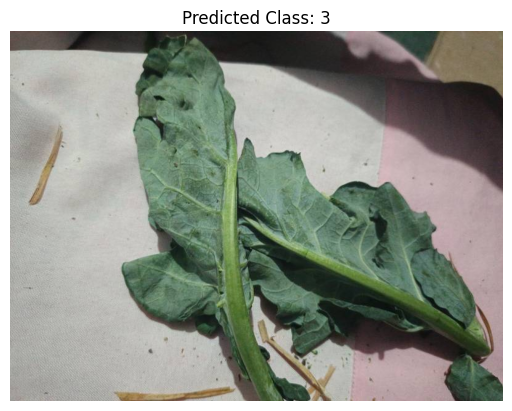

In [24]:
# Ruta de la imagen a probar
# image_path = '/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio2/Dataset/train/Bolsas-Soda/imagen_2312.jpg'  # Cambia esto a la ruta de tu imagen
# image_path = '/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio2/Dataset/train/Anillo-De-Lata/IMG_20250810_194009_223.jpg'
# image_path = '/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio2/Dataset/train/Cable-De-Red/imagen_6011.jpg'
# image_path = '/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio2/Dataset/train/Hojas-Brocoli/IMG_20250812_212006045_BURST0001_COVER.jpg'
# image_path = '/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio2/Dataset/train/Monedas/IMG_20250808_185904_930.jpg'
image_path = '/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio2/Dataset/train/Hojas-Brocoli/IMG_20250812_222510374_BURST0017.jpg'

# Obtener la clase predicha
predicted_class = predict_image(image_path)

# Mostrar la imagen y el resultado
image = Image.open(image_path)
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()


    La celda en la primera fila y primera columna (donde dice "Anillo-De-Lata" en ambos ejes) muestra cuántas imágenes de "Anillo-De-Lata" fueron correctamente clasificadas como "Anillo-De-Lata".
    La celda en la primera fila y tercera columna (donde dice "Anillo-De-Lata" en la fila y "Cable-De-Red" en la columna) muestra cuántas imágenes de "Anillo-De-Lata" fueron clasificadas incorrectamente como "Cable-De-Red".


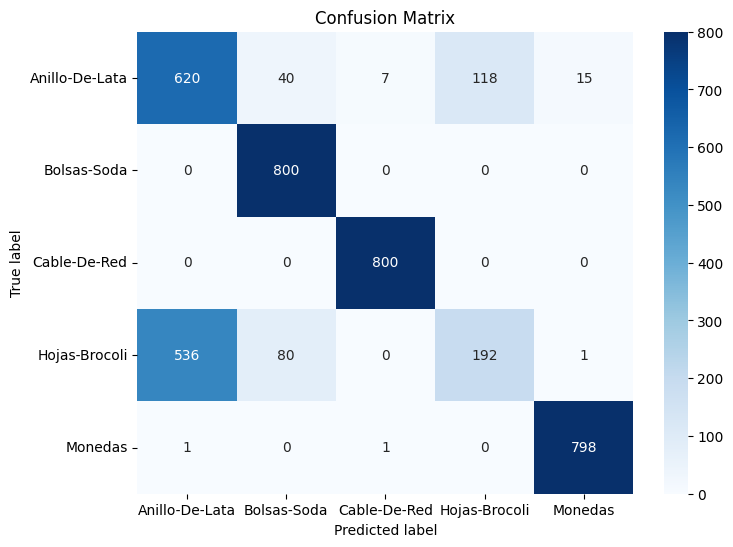

In [25]:
import torch
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que el modelo esté en modo de evaluación
model.eval()

# Listas para almacenar las etiquetas verdaderas y las predicciones
all_labels = []
all_predictions = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Desactivar el cálculo de gradientes
with torch.no_grad():
    for images, labels in dataloader['test']:
        images, labels = images.to(device), labels.to(device)

        # Obtener las predicciones del modelo
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Almacenar las etiquetas y predicciones
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Obtener los nombres de las clases (asumiendo que train_data.classes está disponible)
# Si no, puedes definir una lista manualmente con los nombres de tus clases
class_names = train_data.classes if 'train_data' in locals() and hasattr(train_data, 'classes') else [str(i) for i in range(len(np.unique(all_labels)))]


# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [26]:
# Ejecutar el entrenamiento y obtener el historial
training_history = fit(model, dataloader, epochs=10, lr=1e-3, weight_decay=1e-4, save_interval=2)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
val_loss 1.68837 val_acc 0.79812: 100%|██████████| 63/63 [00:31<00:00,  2.02it/s]


Epoch 1/10 - loss: 0.01729, val_loss: 1.68837, acc: 0.99414, val_acc: 0.79812


val_loss 2.97032 val_acc 0.77455: 100%|██████████| 63/63 [00:31<00:00,  1.98it/s]


Epoch 2/10 - loss: 0.01608, val_loss: 2.97032, acc: 0.99658, val_acc: 0.77455
Checkpoint guardado en: /content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio2/checkpoint_epoch_2.pth


val_loss 2.30726 val_acc 0.77902: 100%|██████████| 63/63 [00:31<00:00,  2.03it/s]


Epoch 3/10 - loss: 0.02419, val_loss: 2.30726, acc: 0.99414, val_acc: 0.77902


val_loss 3.23586 val_acc 0.63194: 100%|██████████| 63/63 [00:30<00:00,  2.06it/s]


Epoch 4/10 - loss: 0.01227, val_loss: 3.23586, acc: 0.99805, val_acc: 0.63194
Checkpoint guardado en: /content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio2/checkpoint_epoch_4.pth


val_loss 2.53961 val_acc 0.80332: 100%|██████████| 63/63 [00:31<00:00,  2.02it/s]


Epoch 5/10 - loss: 0.00759, val_loss: 2.53961, acc: 0.99854, val_acc: 0.80332


val_loss 2.33867 val_acc 0.82540: 100%|██████████| 63/63 [00:30<00:00,  2.04it/s]


Epoch 6/10 - loss: 0.00600, val_loss: 2.33867, acc: 0.99951, val_acc: 0.82540
Checkpoint guardado en: /content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio2/checkpoint_epoch_6.pth


val_loss 2.50913 val_acc 0.82440: 100%|██████████| 63/63 [00:36<00:00,  1.73it/s]


Epoch 7/10 - loss: 0.00051, val_loss: 2.50913, acc: 1.00000, val_acc: 0.82440


val_loss 2.34828 val_acc 0.82391: 100%|██████████| 63/63 [00:30<00:00,  2.04it/s]


Epoch 8/10 - loss: 0.00588, val_loss: 2.34828, acc: 0.99902, val_acc: 0.82391
Checkpoint guardado en: /content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio2/checkpoint_epoch_8.pth


val_loss 2.48149 val_acc 0.83209: 100%|██████████| 63/63 [00:31<00:00,  2.03it/s]


Epoch 9/10 - loss: 0.00088, val_loss: 2.48149, acc: 0.99951, val_acc: 0.83209


val_loss 2.40909 val_acc 0.83160: 100%|██████████| 63/63 [00:31<00:00,  1.99it/s]

Epoch 10/10 - loss: 0.00068, val_loss: 2.40909, acc: 1.00000, val_acc: 0.83160
Checkpoint guardado en: /content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio2/checkpoint_epoch_10.pth


##Curva de Aprendizaje

A continuación se presenta la gráfica de la curva de aprendizaje del modelo, mostrando la pérdida y la precisión tanto para el conjunto de entrenamiento como para el conjunto de validación a lo largo de las épocas. Esto nos permite visualizar cómo el modelo aprende y si hay signos de sobreajuste o subajuste.

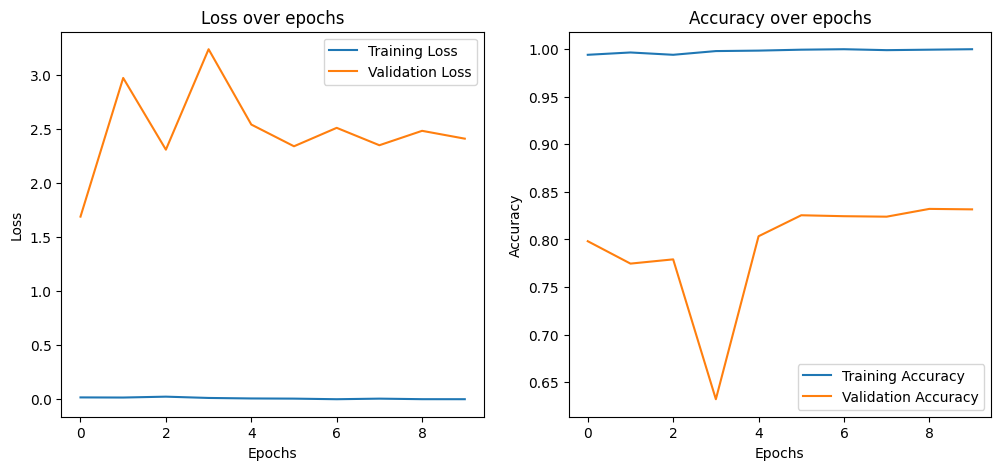

In [27]:
import matplotlib.pyplot as plt

# Graficar la pérdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(training_history['train_loss'], label='Training Loss')
plt.plot(training_history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Graficar la precisión
plt.subplot(1, 2, 2)
plt.plot(training_history['train_acc'], label='Training Accuracy')
plt.plot(training_history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()